## In this Assignment We are going to perfrom time series forcasting on temperature using the Deep Neural Network on jena_climate_2009_2016 dataset

#### Importing the required module for our Assignment

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import os
import sys
from math import ceil,floor

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import load_model

#### Loading the Data Set from tf-keras-dataset which is hosted on google cloud storage on which we will perform our timeseries forcasting using DNN

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

In [5]:
zip_path

'C:\\Users\\zidan\\.keras\\datasets\\jena_climate_2009_2016.csv.zip'

In [6]:
csv_path, _ = os.path.splitext(zip_path)

In [7]:
df = pd.read_csv(csv_path)

In [8]:
len(df)

420551

In [9]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


##### Our timeseries dataset is of 10 min interval but we want to do our analysis on hourly interval. So we will fetch hourly interval values from our dataframe 

In [11]:
# making the data hourly
df = df[5::6] # 5th index has 1st hour reading so starting from there then every 6th index will be the next hour reading therefore setting step_size=6

In [12]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [13]:
len(df) # size of our dataset decreased from 420551 to 70091

70091

##### setting Date Time column as index and Dropping it as a column

In [14]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.drop('Date Time',axis=1,inplace=True)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


##### We will only do our time series forcating on Temperature column

<Axes: xlabel='Date Time'>

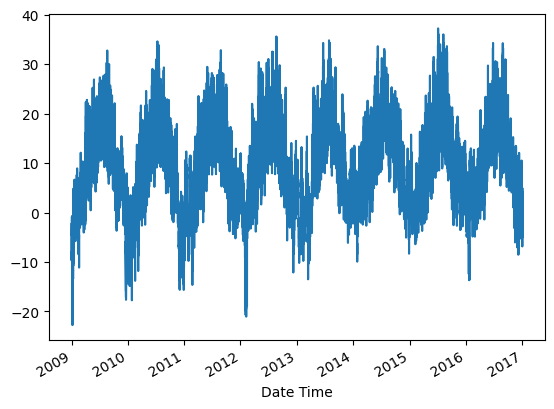

In [15]:
temp = df['T (degC)']
temp.plot()

In [16]:
temp_arr = temp.to_numpy()

##### Lets create Features and Label. We will use previous a window of size 'n' Which basically say how much values we need to look back to predict next value

In [17]:
from typing import Tuple 

In [18]:
def df_to_X_y(arr: [np.ndarray,pd.core.series.Series], window_size: int=5) -> Tuple[np.ndarray,np.ndarray]: 
    """Gets and transform the data into features and label based on window_size
    
    Args:
        arr (np.ndarray,pd.core.series.Series): data to be transformed into features and labels
        window_size (int): window_size say how much previous value to be dependent on for target 
            (default is 5)
    
    Returns:
        tupe: a tuple of features and label
    """
    if isinstance(arr,pd.core.series.Series):
        arr = arr.to_numpy()
    if not isinstance(arr,np.ndarray):
        raise TypeError(f'The input data need to be of Type {np.ndarray} or {pd.core.series.Series}')
    X = []
    y = []
    for i in range(len(arr)-window_size):
        #row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(arr[i:i+window_size])
        label = arr[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

### WINDOW SIZE = 5

In [19]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp_arr, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5), (70086,))

##### Splitting our dataset into Train,Test and Validation split

In [20]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5), (60000,), (5000, 5), (5000,), (5086, 5), (5086,))

In [21]:
X_train1

array([[-8.05, -8.88, -8.81, -9.05, -9.63],
       [-8.88, -8.81, -9.05, -9.63, -9.67],
       [-8.81, -9.05, -9.63, -9.67, -9.17],
       ...,
       [ 2.02,  2.27,  4.71,  6.07,  9.88],
       [ 2.27,  4.71,  6.07,  9.88, 13.53],
       [ 4.71,  6.07,  9.88, 13.53, 15.43]])

##### Creating our Deep neural network model

In [22]:
tf.random.set_seed(42)

In [23]:
model1 = Sequential() # we will be using tenserflow sequential API for modelling

In [24]:
model1.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [25]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model1.add(Dropout(0.2))

In [26]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model1.add(Dropout(0.2))

In [27]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model1.add(Dropout(0.05))

In [28]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE,activation='relu'))
# model1.add(Dropout(0.2))

In [29]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model1.add(Dense(1,activation='linear'))

In [30]:
model1.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 50)                   300       
                                                                 
 dense_1 (Dense)             (1, 30)                   1530      
                                                                 
 dense_2 (Dense)             (1, 15)                   465       
                                                                 
 dense_3 (Dense)             (1, 5)                    80        
                                                                 
 dense_4 (Dense)             (1, 1)                    6         
                                                                 
Total params: 2381 (9.30 KB)
Trainable params: 2381 (9.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [32]:
cp1 = ModelCheckpoint('models/temperature_forcast/model1', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [33]:
logdir = 'logs/temperature_forcast/model2'

In [34]:
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [35]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [36]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist1 = model1.fit(~X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1,tensorboard_callback1,patience])

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
hist1.history.keys()

#### Plot Performance

##### MSE LOSS PLOT

In [ ]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist1.history['loss'], color='teal', label='loss')
plt.plot(hist1.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

In [ ]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist1.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist1.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# loading the model
model1 = load_model('models/temperature_forcast/model1/')

In [ ]:
# predicting train dataset on loaded model
train_predictions1 = model1.predict(X_train1).flatten()
# storing predicted and actual in a dataframe
train_results1 = pd.DataFrame(data={'Train Predictions':train_predictions1, 'Actuals':y_train1})
train_results1.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results1['Train Predictions'][:100])
plt.plot(train_results1['Actuals'][:100])

In [ ]:
# predicting validation dataset on loaded model
val_predictions1 = model1.predict(X_val1).flatten()
# storing predicted and actual in a dataframe
val_results1 = pd.DataFrame(data={'Val Predictions':val_predictions1, 'Actuals':y_val1})
val_results1.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results1['Val Predictions'][:100])
plt.plot(val_results1['Actuals'][:100])

In [ ]:
# predicting validation dataset on loaded model
test_predictions1 = model1.predict(X_test1).flatten()
# storing predicted and actual in a dataframe
test_results1 = pd.DataFrame(data={'Test Predictions':test_predictions1, 'Actuals':y_test1})
test_results1.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results1['Test Predictions'][:100])
plt.plot(test_results1['Actuals'][:100])

### WINDOW SIZE = 10

In [ ]:
WINDOW_SIZE = 10
X2, y2 = df_to_X_y(temp_arr, WINDOW_SIZE)
X2.shape, y2.shape

##### Splitting our dataset into Train,Test and Validation split

In [ ]:
X_train2, y_train2 = X2[:60000], y2[:60000]
X_val2, y_val2 = X2[60000:65000], y2[60000:65000]
X_test2, y_test2 = X2[65000:], y2[65000:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

In [ ]:
X_train2

##### Creating our Deep neural network model

In [ ]:
tf.random.set_seed(42)

In [ ]:
model2 = Sequential() # we will be using tenserflow sequential API for modelling

In [ ]:
model2.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [ ]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model2.add(Dropout(0.2))

In [ ]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model2.add(Dropout(0.2))

In [ ]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model2.add(Dropout(0.05))

In [ ]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE,activation='relu'))
# model2.add(Dropout(0.2))

In [ ]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model2.add(Dense(1,activation='linear'))

In [ ]:
model2.summary() # checking the summary of our sequential model like how much param it train on each layer etc

In [ ]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
cp2 = ModelCheckpoint('models/temperature_forcast/model2', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [ ]:
logdir = 'logs/temperature_forcast/model2'

In [ ]:
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [ ]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [ ]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2,tensorboard_callback2,patience])

In [ ]:
hist2.history.keys()

#### Plot Performance

##### MSE LOSS PLOT

In [ ]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

In [ ]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist2.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist2.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# loading the model
model2 = load_model('models/temperature_forcast/model2/')

In [ ]:
# predicting train dataset on loaded model
train_predictions2 = model2.predict(X_train2).flatten()
# storing predicted and actual in a dataframe
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train2})
train_results2.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results2['Train Predictions'][:100])
plt.plot(train_results2['Actuals'][:100])

In [ ]:
# predicting validation dataset on loaded model
val_predictions2 = model2.predict(X_val2).flatten()
# storing predicted and actual in a dataframe
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val2})
val_results2.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results2['Val Predictions'][:100])
plt.plot(val_results2['Actuals'][:100])

In [ ]:
# predicting validation dataset on loaded model
test_predictions2 = model2.predict(X_test2).flatten()
# storing predicted and actual in a dataframe
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actuals':y_test2})
test_results2.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results2['Test Predictions'][:100])
plt.plot(test_results2['Actuals'][:100])

### WINDOW SIZE = 15

In [ ]:
WINDOW_SIZE = 15
X3, y3 = df_to_X_y(temp_arr, WINDOW_SIZE)
X3.shape, y3.shape

##### Splitting our dataset into Train,Test and Validation split

In [ ]:
X_train3, y_train3 = X3[:60000], y3[:60000]
X_val3, y_val3 = X3[60000:65000], y3[60000:65000]
X_test3, y_test3 = X3[65000:], y3[65000:]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

In [ ]:
X_train3

##### Creating our Deep neural network model

In [ ]:
tf.random.set_seed(42)

In [ ]:
model3 = Sequential() # we will be using tenserflow sequential API for modelling

In [ ]:
model3.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [ ]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model3.add(Dropout(0.2))

In [ ]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model3.add(Dropout(0.2))

In [ ]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model3.add(Dropout(0.05))

In [ ]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE,activation='relu'))
# model3.add(Dropout(0.2))

In [ ]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model3.add(Dense(1,activation='linear'))

In [ ]:
model3.summary() # checking the summary of our sequential model like how much param it train on each layer etc

In [ ]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
cp3 = ModelCheckpoint('models/temperature_forcast/model3', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [ ]:
logdir = 'logs/model3'

In [ ]:
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [ ]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [ ]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3,tensorboard_callback3,patience])

In [ ]:
hist3.history.keys()

#### Plot Performance

##### MSE LOSS PLOT

In [ ]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist3.history['loss'], color='teal', label='loss')
plt.plot(hist3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

In [ ]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist3.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist3.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# loading the model
model3 = load_model('models/temperature_forcast/model3/')

In [ ]:
# predicting train dataset on loaded model
train_predictions3 = model3.predict(X_train3).flatten()
# storing predicted and actual in a dataframe
train_results3 = pd.DataFrame(data={'Train Predictions':train_predictions3, 'Actuals':y_train3})
train_results3.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results3['Train Predictions'][:100])
plt.plot(train_results3['Actuals'][:100])

In [ ]:
# predicting validation dataset on loaded model
val_predictions3 = model3.predict(X_val3).flatten()
# storing predicted and actual in a dataframe
val_results3 = pd.DataFrame(data={'Val Predictions':val_predictions3, 'Actuals':y_val3})
val_results3.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results3['Val Predictions'][:100])
plt.plot(val_results3['Actuals'][:100])

In [ ]:
# predicting validation dataset on loaded model
test_predictions3 = model3.predict(X_test3).flatten()
# storing predicted and actual in a dataframe
test_results3 = pd.DataFrame(data={'Test Predictions':test_predictions3, 'Actuals':y_test3})
test_results3.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results3['Test Predictions'][:100])
plt.plot(test_results3['Actuals'][:100])

### WINDOW SIZE = 20

In [ ]:
WINDOW_SIZE = 20
X4, y4 = df_to_X_y(temp_arr, WINDOW_SIZE)
X4.shape, y4.shape

##### Splitting our dataset into Train,Test and Validation split

In [ ]:
X_train4, y_train4 = X4[:60000], y4[:60000]
X_val4, y_val4 = X4[60000:65000], y4[60000:65000]
X_test4, y_test4 = X4[65000:], y4[65000:]
X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

In [ ]:
X_train4

##### Creating our Deep neural network model

In [ ]:
tf.random.set_seed(42)

In [ ]:
model4 = Sequential() # we will be using tenserflow sequential API for modelling

In [ ]:
model4.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [ ]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model4.add(Dropout(0.2))

In [ ]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model4.add(Dropout(0.2))

In [ ]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model4.add(Dropout(0.05))

In [ ]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE,activation='relu'))
# model4.add(Dropout(0.2))

In [ ]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model4.add(Dense(1,activation='linear'))

In [ ]:
model4.summary() # checking the summary of our sequential model like how much param it train on each layer etc

In [ ]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
cp4 = ModelCheckpoint('models/temperature_forcast/model4', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [ ]:
logdir = 'logs/temperature_forcast/model4'

In [ ]:
tensorboard_callback4 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [ ]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [ ]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4,tensorboard_callback4,patience])

In [ ]:
hist4.history.keys()

#### Plot Performance

##### MSE LOSS PLOT

In [ ]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist4.history['loss'], color='teal', label='loss')
plt.plot(hist4.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

In [ ]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist4.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist4.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# loading the model
model4 = load_model('models/temperature_forcast/model4/')

In [ ]:
# predicting train dataset on loaded model
train_predictions4 = model4.predict(X_train4).flatten()
# storing predicted and actual in a dataframe
train_results4 = pd.DataFrame(data={'Train Predictions':train_predictions4, 'Actuals':y_train4})
train_results4.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results4['Train Predictions'][:100])
plt.plot(train_results4['Actuals'][:100])

In [ ]:
# predicting validation dataset on loaded model
val_predictions4 = model4.predict(X_val4).flatten()
# storing predicted and actual in a dataframe
val_results4 = pd.DataFrame(data={'Val Predictions':val_predictions4, 'Actuals':y_val4})
val_results4.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results4['Val Predictions'][:100])
plt.plot(val_results4['Actuals'][:100])

In [ ]:
# predicting validation dataset on loaded model
test_predictions4 = model4.predict(X_test4).flatten()
# storing predicted and actual in a dataframe
test_results4 = pd.DataFrame(data={'Test Predictions':test_predictions4, 'Actuals':y_test4})
test_results4.head()

In [ ]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results4['Test Predictions'][:100])
plt.plot(test_results4['Actuals'][:100])